# Objective:

We are going to build a model that predicts if someone who seeks a loan might be a defaulter or a non-defaulter. We have several independent variables like, checking account balance, credit history, purpose, loan amount etc.

We are going to use different classifiers like  Classifiers *Randon Forest, XGBoost Classifier, and Bagging Classifier*, we are going to tune the models, evaluate the models using ROC, Confusion Matrix, and use metrics like F1 and Recall, we are going to identify what are the key features to make predictions and describe suggestions to be business.


# Import Libraries

In [19]:
import random
# Libraries to help with reading and data manipulation
import pandas as pd
import numpy as np
import pandas.core.series
from pandas import Series
#from pandasgui import show
import modin.pandas as modi_pd
import pandas_bokeh

pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource
# disble Warning
#warnings.filterwarnings("ignore", category=DeprecationWarning)

# OS Libraries
import os

# GeoPandas add support for geographic data to pandas objects.
import geopandas


# Debugging Library
from icecream import install
import icecream as ic
install()


# Libraries for reporting
#from pandas_profiling import ProfileReport

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 1
import matplotlib.font_manager as font_manager
# plt.matplotlib.font_manager._load_fontmanager(try_read_cache=False)
import bar_chart_race as bcr

import seaborn as sns
# Library to avoid the warnings3
import warnings
warnings.filterwarnings("ignore")
# Libraries to work with dates
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import scipy.stats as stats
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

#To install xgboost library use - !pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings

# Imputing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
import imblearn.under_sampling as under
from imblearn.under_sampling import RandomUnderSampler


import pprint


Loading BokehJS ...

# Functions Definition

In [20]:
def first_steps_eda(**kwargs) -> None:
  """
  Load and describe the data set
  """

  (df := kwargs.get("data_frame"))


  # get the size of dataframe
  print('[*] Data has {} samples and {} features.'.format(df.shape[0], df.shape[1]))
  print("-" * 100)
  print(f"[*] Features : {df.columns.to_list()}\n\n")  # get name of columns/features

  print("-" * 100)
  print("[*] Missing values :\n\n", df.isnull().sum().sort_values(ascending=False))
  print("-" * 100)
  print("[*] Percent of missing :\n\n",
        round(df.isna().sum() / df.isna().count() * 100, 2).sort_values(ascending=False))
  print("-" * 100)
  print("[*] Dataset Info :")
  print(df.info())
  print("-" * 100)
  print("[*] Unique Values: ")
  print(df.nunique())
  print("-" * 100)
  '''
  print("\n[*] Checking for Unique Values: ")
  for feature_name in df.columns.tolist():  # Check for the unique values in the data
    print("Unique values in the column '{}' are \n\n".format(feature_name), data[feature_name].unique())
    print("-" * 100)
  '''
  print("\n[*] Descriptive Statistics from the Data")
  print(f"{df.describe().T}")
  print("-" * 100)
  print("\n[*] Outliers Identification ")
  for feature in df.select_dtypes(include=np.number).columns:  # Identifying Outliers
    identify_outliers_by_feature(df=data, feature=feature)

def identify_outliers_by_feature(df: pd.DataFrame, feature: str) -> None:
    """
    Identified Outliers in a variable
    :param df:
    :param feature:
    :return None:
        """
    # Calculate intrequatile range
    q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
    iqr = q75 - q25
    print(f"Feature: {feature} \nIQR: {iqr}\nQ25: {q25}\nQ75: {q75}")
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f"CutOff: {cut_off}\nLower: {lower}\nUpper: {upper}")
    # identify outliers
    outliers = [x for x in df[feature] if x < lower or x > upper]
    print("Outliers Identified:")
    print(pd.Series(outliers).sort_values(ascending=False))
    print("==" * 10)

def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()

    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))

    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

def identify_correlated_features(df: pd.DataFrame, threshold: float)-> list:
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()

    # Create a boolean mask
    # create a boolean mask which will be used to subset the matrix:
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Subset the matrix
    # Using the mask method of Pandas DataFrames (correlation matrix is a DataFrame) puts NaN values to the upper half and diagonal of the matrix
    reduced_matrix = matrix.mask(mask)

    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]

    return to_drop

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.figure(figsize=(10,5))
    plt.show()  # show the plot

# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="red", linestyle="-"
    )  # Add median to the histogram

def stacked_plot(x: Series,  y :Series):
    sns.set(palette='Dark2')
    tab1 = pd.crosstab(x,y,margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,y,normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.legend(loc='lower left', frameon=True)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.ylabel('Percentage')
    plt.show()

def distribution_plot_feature_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title(f"Distribution of target={target} for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title(f"Distribution of target={target} for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title(f"Boxplot {target} target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title(f"Boxplot (without outliers) {target} target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

# functions to treat outliers
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

# defining a function to compute different metrics to check performance of a classification model built using sklearn

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

#####

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


def auc_plot(clfrs : dict, x_test: pd.core.frame.DataFrame, y_test : pd.core.series.Series) -> None:
    """
    :param clfrs: Dictionary of Binary Classifiers along with the names
    :param x_test: pandas Dataframe of test data
    :param y_test: pandas Series of test data
    :return: Plot AUC
    """
    for name, clsfr in clfrs.items():
        pred_prob = clsfr.predict_proba(x_test)  # In the context of classification tasks, some sklearn estimators also implement the predict_proba method that returns the class probabilities for each data point.
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)  # Extract fpr, tpr and threshold

        # auc scores
        auc_score = roc_auc_score(y_test, pred_prob[:,1])  # Get ROC-AUC Score

        # matplotlib
        import random
        # Random Linestyle
        linestyle_list = ['-', '--', '-.', ':']
        linestyle = linestyle_list[random.randrange(start=0, stop=len(linestyle_list), step=1)]
        plt.style.use('seaborn')

        # Colors
        # Random Colors
        colors = ['blue','green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'darkorange']
        color = colors[random.randrange(start=0 , stop=len(colors), step=2)]


        # plot roc curves
        plt.plot(fpr, tpr, linestyle=linestyle, color=color, label=f"{name} (AUC={auc_score:.2f})")



    plt.plot([0, 1], [0, 1], linestyle="solid", color='red', label="Chance level (AUC = 0.5)")
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show()



# Importing Data

In [21]:
data = pd.read_csv("credit.csv")
data_backup = data.copy()# Backup
data.sample(10)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
412,unknown,12,critical,business,2292,< 100 DM,unemployed,4,2,42,store,own,2,management,1,yes,yes
678,< 0 DM,24,good,furniture/appliances,2384,< 100 DM,> 7 years,4,4,64,bank,rent,1,unskilled,1,no,no
916,unknown,10,good,car,2848,100 - 500 DM,1 - 4 years,1,2,32,none,own,1,skilled,2,no,no
555,1 - 200 DM,12,good,furniture/appliances,1331,< 100 DM,< 1 year,2,1,22,store,own,1,skilled,1,no,yes
997,unknown,12,good,furniture/appliances,804,< 100 DM,> 7 years,4,4,38,none,own,1,skilled,1,no,no
851,unknown,24,critical,car,4042,unknown,4 - 7 years,3,4,43,none,own,2,skilled,1,yes,no
53,unknown,18,good,car,3378,unknown,1 - 4 years,2,1,31,none,own,1,skilled,1,yes,no
368,< 0 DM,36,good,furniture/appliances,3446,< 100 DM,> 7 years,4,2,42,none,own,1,skilled,2,no,yes
29,< 0 DM,60,poor,business,6836,< 100 DM,> 7 years,3,4,63,none,own,2,skilled,1,yes,yes
689,< 0 DM,12,good,car,3651,> 1000 DM,1 - 4 years,1,3,31,none,own,1,skilled,2,no,no


# EDA

## First Steps EDA

In [22]:
first_steps_eda(data_frame=data)

[*] Data has 1000 samples and 17 features.
----------------------------------------------------------------------------------------------------
[*] Features : ['checking_balance', 'months_loan_duration', 'credit_history', 'purpose', 'amount', 'savings_balance', 'employment_duration', 'percent_of_income', 'years_at_residence', 'age', 'other_credit', 'housing', 'existing_loans_count', 'job', 'dependents', 'phone', 'default']


----------------------------------------------------------------------------------------------------
[*] Missing values :

 checking_balance        0
age                     0
phone                   0
dependents              0
job                     0
existing_loans_count    0
housing                 0
other_credit            0
years_at_residence      0
months_loan_duration    0
percent_of_income       0
employment_duration     0
savings_balance         0
amount                  0
purpose                 0
credit_history          0
default                 0
dtype

Observation:

* Independent Variables: ['checking_balance', 'months_loan_duration', 'credit_history', 'purpose', 'amount', 'savings_balance', 'employment_duration', 'percent_of_income', 'years_at_residence', 'age', 'other_credit', 'housing', 'existing_loans_count', 'job', 'dependents', 'phone', 'default']
* Depend variable: default
* Data has 1000 samples and 17 features.
* No missing values
* Unique Values:
checking_balance          4
months_loan_duration     33
credit_history            5
purpose                   6
amount                  921
savings_balance           5
employment_duration       5
percent_of_income         4
years_at_residence        4
age                      53
other_credit              3
housing                   3
existing_loans_count      4
job                       4
dependents                2
phone                     2
default                   2
* Outliers: months_loan_duration, amount, percent_of_income, years_at_residence, age, existing_loans_count,and dependents



## Univariate Analysis
### Independent Variable Default

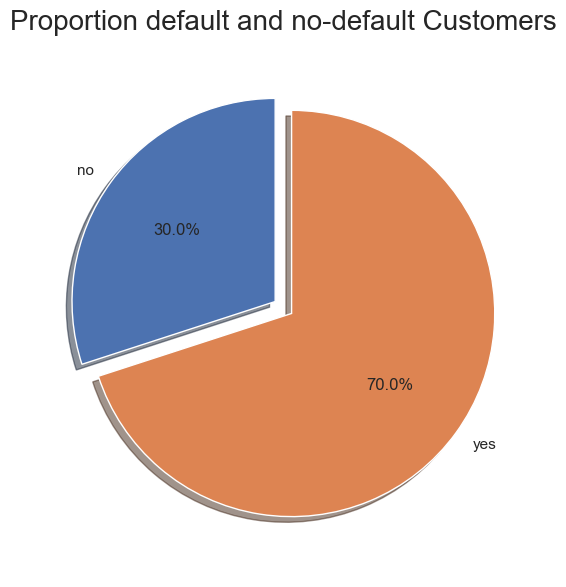

In [23]:
labels =["no", "yes"]
count = [data.default[data.default == 'yes'].count(), data.default[data.default == 'no'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(6, 7))
ax1.pie(count,  labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion default and no-default Customers", size = 20)
plt.show()

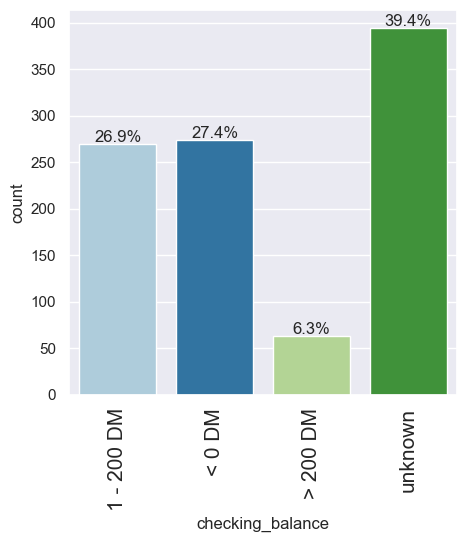

<Figure size 1000x500 with 0 Axes>

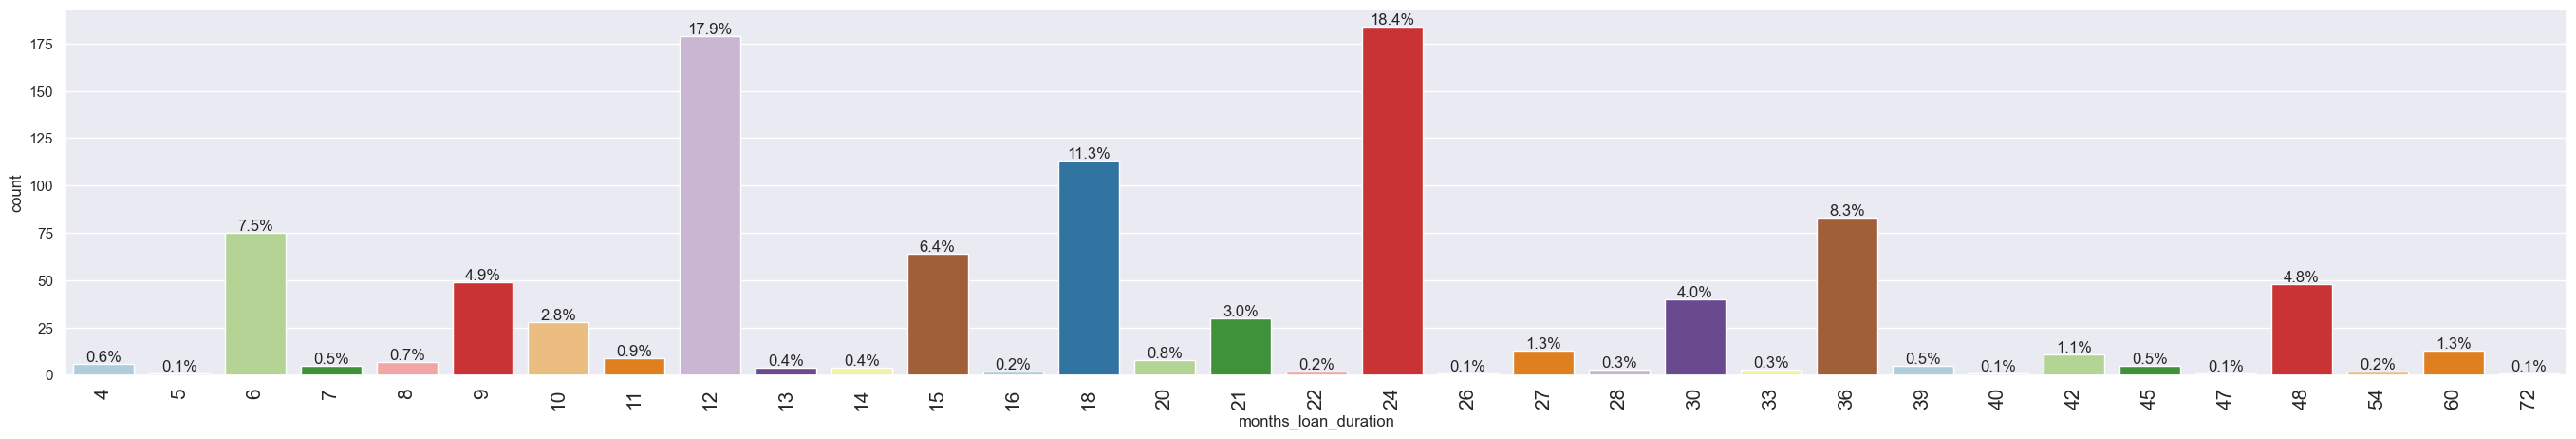

<Figure size 1000x500 with 0 Axes>

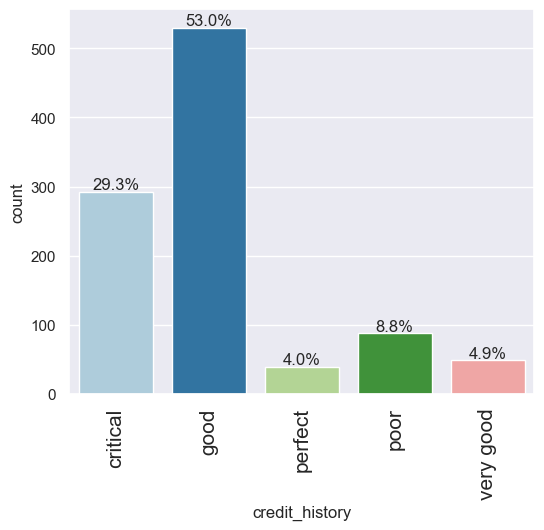

<Figure size 1000x500 with 0 Axes>

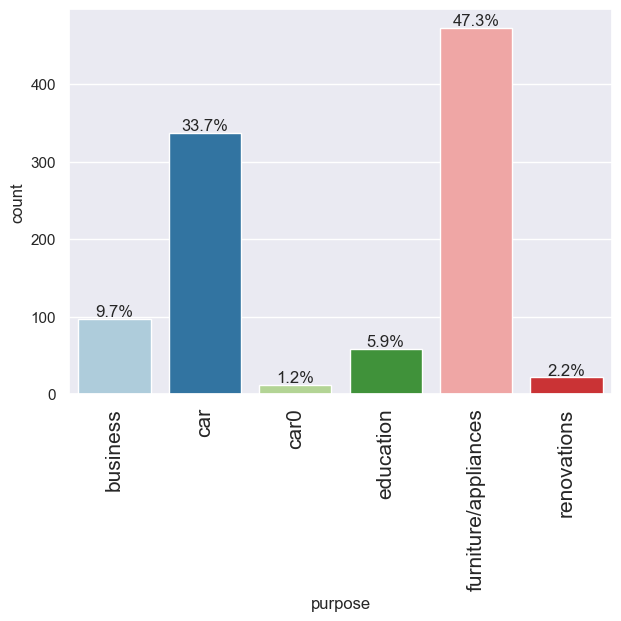

<Figure size 1000x500 with 0 Axes>

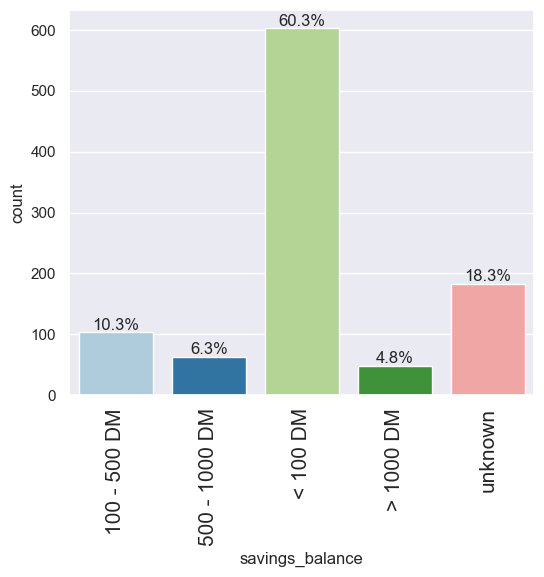

<Figure size 1000x500 with 0 Axes>

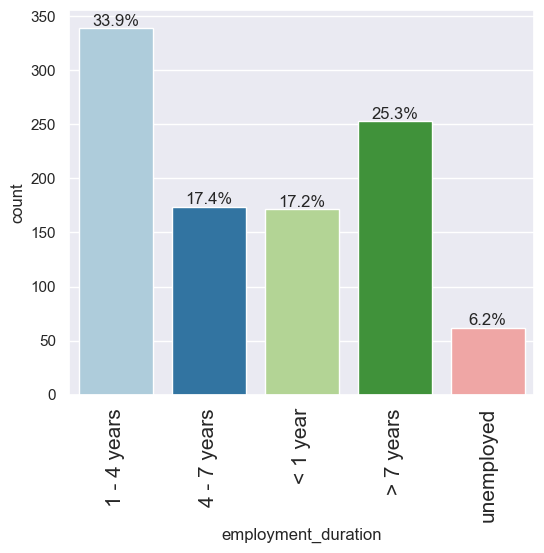

<Figure size 1000x500 with 0 Axes>

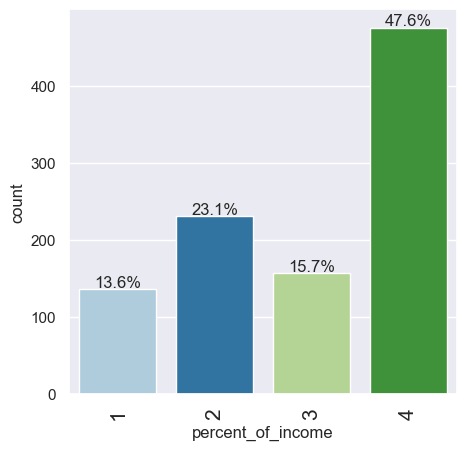

<Figure size 1000x500 with 0 Axes>

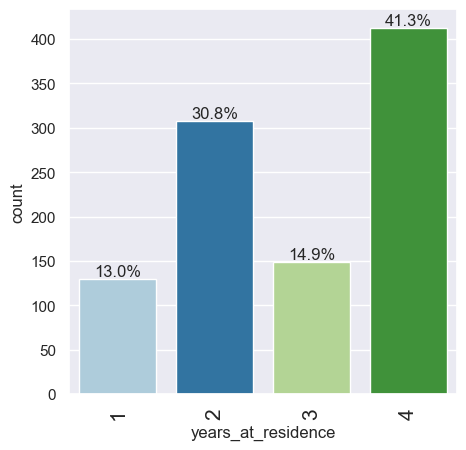

<Figure size 1000x500 with 0 Axes>

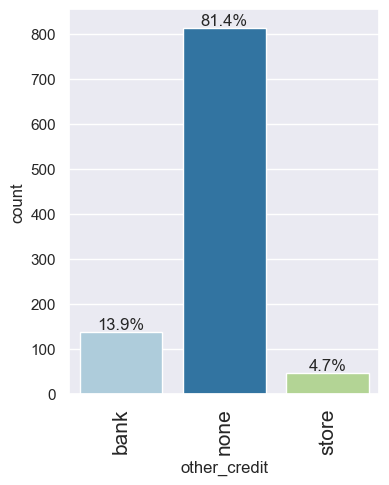

<Figure size 1000x500 with 0 Axes>

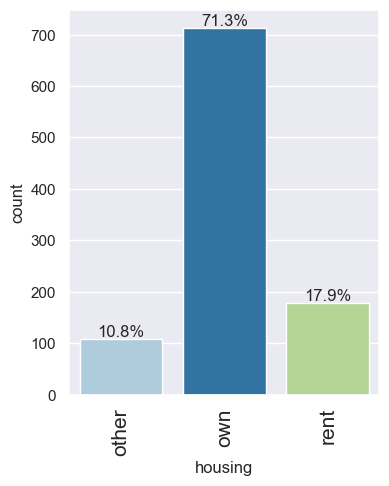

<Figure size 1000x500 with 0 Axes>

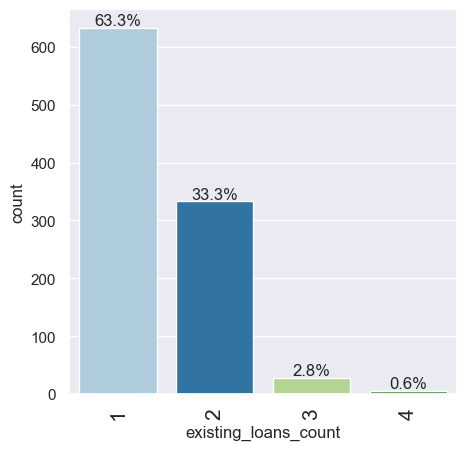

<Figure size 1000x500 with 0 Axes>

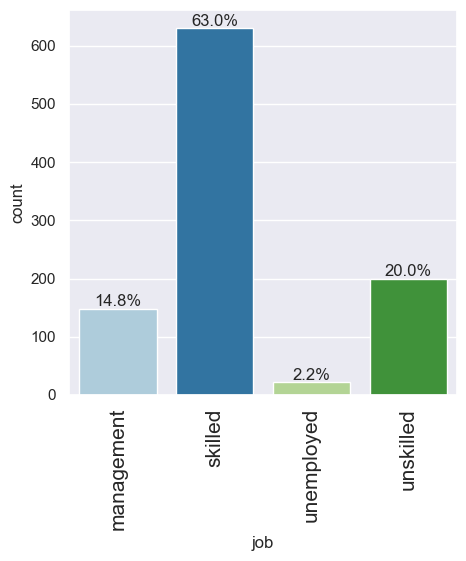

<Figure size 1000x500 with 0 Axes>

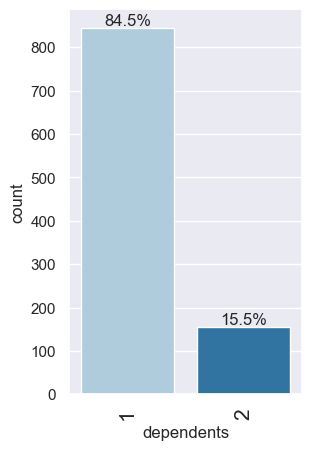

<Figure size 1000x500 with 0 Axes>

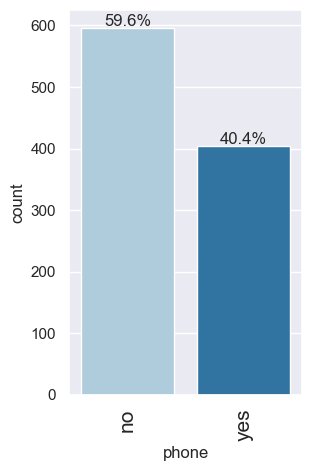

<Figure size 1000x500 with 0 Axes>

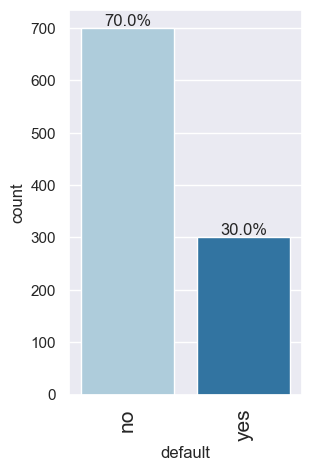

<Figure size 1000x500 with 0 Axes>

In [24]:
for col in data.columns:
    if col == 'age' or col == 'amount':
        continue
    labeled_barplot(data=data, feature=col, perc=True)

### Observations:
* This is an imbalance dataset 70% = No , Yes = 30%


## Bivariate Analysis

In [25]:
sns.set(rc={'figure.figsize':(18,10)})
#data_4Corr  = data.select_dtypes(include='number')
sns.heatmap(data.corr()>0.9, annot=True,vmin=-1,vmax=1,fmt='.2f',cmap="Spectral")
plt.show()


ValueError: could not convert string to float: '< 0 DM'

Objec



# Model Building Approach

1. Data Preparation
2. Partition the data into train, test set
3. Build model on the train
4. Tune the model if required
5. Test the data on test set


## Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting a customer will default and the customer doesn't default
2. Predicting a customer will not default and the customer default

### Which case is more important?
* Predicting a customer will not default but the customer default i.e. losing on a valuable customer or asset.

### How to reduce this loss i.e need to reduce False Negatives?
* The bank wants Recall to be maximized, greater the Recall higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall or minimizing the false negatives or in other words identifying the true positives(i.e. Class 1) so that the company can provide incentives to merchants and control attrition rate thereby optimizing the overall project cost in retaining the best customers.

* When classification problems exhibit a significant imbalance in the distribution of the target classes, it is good to use stratified sampling to ensure that relative class frequencies are approximately preserved in train, validation and test sets.


# Feature Engineering

In [ ]:
# Data Preprocessing - data types
'''
for feature in data.select_dtypes(include='object').columns.tolist():  # Loop over object type, change the dtype to category
    data[feature] = data[feature].astype(dtype='category')
    '''

data.age = data['age'].astype('int64')
data.amount = data['amount'].astype('int64')

## Copy the data before Feature Engineering
df = data.copy()

In [ ]:

# Let's preserve the order of these of different uniques values for checking_balance, credit_history, savings_balance, employment_duration, phone

replaceStruct = {
                "checking_balance":     {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration":     {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone":     {"no": 1, "yes": 2 },
                "job":     {"unemployed": 1, "unskilled": 2, "skilled": 3, "management": 4 },
                "default":     {"no": 0, "yes": 1 }
                    }

data = data.replace(replaceStruct)  # Replace values with the new ones


In [ ]:
df.columns

In [ ]:
## Categorical Features - OneHotEncoding

oneHotCols=["purpose","housing","other_credit"]

data =pd.get_dummies(data, columns=oneHotCols)
data.head(10)

In [ ]:
data = data.astype('int64')

# Data Preparation
## Split Data into Train and Test

- When data (classification) exhibit a significant imbalance in the distribution of the target classes, it is good to use stratified sampling to ensure that relative class frequencies are approximately preserved in train and test sets.
- This is done by setting the `stratify` parameter to target variable in the train_test_split function.

In [ ]:
X = data.drop("default", axis=1)
y = data.pop("default")

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=.30, stratify=y, random_state=1)



## Building  models
- We are going to build 4 ensemble models here - Bagging Classifier, Random Forest Classifier, XGBoost, and RandomForest tuned
- First, let's build these models with default parameters and then use hyperparameter tuning to optimize the model performance.
- We will calculate all three metrics - Accuracy, Precision and Recall but the metric of interest here is recall.
- `Recall` - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter

In [ ]:
models = {}


### **Bagging Classifier**


In [ ]:
# base_estimator for bagging classifier is a decision tree by default

bagging_clf = BaggingClassifier(random_state=1)
bagging_clf = bagging_clf.fit(X_train,y_train)
models.update({'Bagging Classifier': bagging_clf})

### Confusion Matrix and Performance -  Training and Test

In [ ]:
confusion_matrix_sklearn(bagging_clf, X_train, y_train)

In [ ]:
model_performance_classification_sklearn(bagging_clf,X_train, y_train)

In [ ]:
confusion_matrix_sklearn(bagging_clf, X_test, y_test)

In [ ]:
bagging_model_test_perf = model_performance_classification_sklearn(bagging_clf,X_test, y_test)
bagging_model_test_perf

Observations:

* The model with the default parameter does not perform well in testing (out of sample)

### **Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
models.update({'Random Forest': rf})

### Confusion Matrix and Performance -  Training and Test

In [ ]:
confusion_matrix_sklearn(rf,X_train, y_train)


In [ ]:
model_performance_classification_sklearn(rf,X_train, y_train)


In [ ]:
confusion_matrix_sklearn(rf,X_test, y_test)


In [ ]:
rf_model_test_perf = model_performance_classification_sklearn(rf,X_test, y_test)
rf_model_test_perf

### Observations:

* RF and Bagging Classifier are both overfiting,  Bagging Classifier has a better Recall


### **XGBoost Classifier**


In [ ]:
xgbc = XGBClassifier(random_state=1,eval_metric='logloss')
xgbc.fit(X_train, y_train)
models.update({"XGBoost Classifier": xgbc})

### Confusion Matrix and Performance -  Training and Test


In [ ]:
confusion_matrix_sklearn(xgbc,X_train, y_train)

In [ ]:
model_performance_classification_sklearn(xgbc,X_train, y_train)

In [ ]:
confusion_matrix_sklearn(xgbc,X_test, y_test)

In [ ]:
xgbc_model_test_perf = model_performance_classification_sklearn(xgbc,X_test, y_test)
xgbc_model_test_perf

### **Hyper Parameter Tuning**

### Let's try using class_weights for random forest:
- The model performance is not very good. This may be due to the fact that the classes are imbalanced with 70% non-defaulters and 30% defaulters.

- We should make the model aware that the class of interest here is 'defaulters'.

- We can do so by passing the parameter `class_weights` available for random forest. This parameter is not available for the bagging classifier.

- class_weight specifies the weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

- We can choose class_weights={0:0.3,1:0.7} because that is the original imbalance in our data.


### *Grid Search with Cross Validation*
* Grid search is a hyperparameter tuning technique used in machine learning to find the optimal set of hyperparameters for a model. Hyperparameters are parameters that are set before the training process begins and are not learned during the training process.
 In grid search, a set of hyperparameters and their corresponding values are defined in a grid. The grid represents a set of possible combinations of hyperparameters that the model will be trained and tested on. Each combination of hyperparameters is used to train a separate model, and the performance of each model is evaluated using a performance metric such as accuracy or mean squared error. The combination of hyperparameters that results in the best performance on the validation set is then selected as the optimal set of hyperparameters. This set of hyperparameters is used to train the final model on the entire dataset, which can then be used for making predictions on new data. Grid search is a systematic and exhaustive approach to hyperparameter tuning, and it can be time-consuming and computationally expensive for large grids. However, it is a widely used and effective technique for optimizing machine learning models.

### A - Random Forest Classifier - Tuned


In [ ]:

# Grid of parameters to choose from
# Define the parameters for GridSearchCV. The grid represents a set of possible combinations of hyperparameters
parameters = {
    "class_weight": [{0: 0.3, 1: 0.7}],
    "n_estimators": [100,150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
}

parameters_ = {
    'class_weight': [{0: 0.3, 1: 0.7}],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.3],
    'min_samples_leaf': [2,3,4,5],
    'n_estimators': [50, 100],
    'max_depth': [50],
    'class_weight': [{0: 0.3, 1: 0.7}]

}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

In [ ]:
# Initialize the GridSearchCV object
grid_obj = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=parameters, scoring=acc_scorer, cv=5)
# Fit the GridSearchCV object to the training data
grid_obj = grid_obj.fit(X_train, y_train)


# Use the best parameters obtained from GridSearchCV to initialize the classifier
rf_tuned_A = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned_A.fit(X_train, y_train)



### Best Parameters

In [ ]:
grid_obj.best_params_

In [ ]:
models.update({"Random Forest tuned-A": rf_tuned_A})

### Confusion Matrix and Performance -  Training and Test

In [ ]:
confusion_matrix_sklearn(rf_tuned_A, X_train, y_train)

In [ ]:
model_performance_classification_sklearn(rf_tuned_A, X_train, y_train)

In [ ]:
confusion_matrix_sklearn(rf_tuned_A, X_test, y_test)


In [ ]:
rf_tuned_A_model_test_perf = model_performance_classification_sklearn(rf_tuned_A,X_test, y_test)
rf_tuned_A_model_test_perf

### Model Comparison

In [ ]:
models_test_comp = pd.concat([bagging_model_test_perf.T, rf_model_test_perf.T,xgbc_model_test_perf.T, rf_tuned_A_model_test_perf
.T], axis=1)

models_test_comp.columns = [
    "Bagging Classifier",
    "Random Forest Classifier",
    "XGBoost Classifier",
    "A-Tuned Random Forest Classifier"
]

print("Test performance comparison:")
models_test_comp

In [ ]:
auc_plot(clfrs=models, x_test=X_test, y_test=y_test)

* Observation: Tuned Random Forest Classifier provide the best performance among all models showing:
    * Recall: 60%
    * F1: 56%
    * AUC: 78%


### *Random Search with Cross Validation*


In [ ]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# This dataset is imbalance so we can use class_weight, specifies the weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
class_weight = [{0: 0.3, 1: 0.7}]

# Create the random grid
random_grid_ = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight
               }

pprint(random_grid_)



In [ ]:

random_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [{0: 0.3, 1: 0.7}],
    'bootstrap': [True, False]

}




### B - Random Forest Classifier - Tuned


In [26]:
# Use the random search for best hyperparameters
# Configure the Randomized Search:
# Set up the RandomizedSearchCV object, which will perform the random search across the parameter grid. Specify the estimator (Random Forest Classifier), the parameter grid, the number of iterations, and the cross-validation strategy, among other settings.
rnd_srch_obj = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42), param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring=acc_scorer)
# Fit the random search model to the training data
rnd_srch_obj = rnd_srch_obj.fit(X_train, y_train)

NameError: name 'random_grid' is not defined

### Best Parameters

In [27]:
rnd_srch_obj.best_params_

NameError: name 'rnd_srch_obj' is not defined

In [28]:

# Use the best parameters obtained from RandomSearch to initialize the classifier
rf_tuned_B = rnd_srch_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned_B.fit(X_train, y_train)

NameError: name 'rnd_srch_obj' is not defined

In [29]:
models.update({"B-Random Forest tuned": rf_tuned_B})


NameError: name 'models' is not defined

### Confusion Matrix and Performance -  Training and Test


In [30]:
confusion_matrix_sklearn(rf_tuned_B, X_train, y_train)


NameError: name 'rf_tuned_B' is not defined

In [31]:
model_performance_classification_sklearn(rf_tuned_B, X_train, y_train)


NameError: name 'rf_tuned_B' is not defined

In [32]:
confusion_matrix_sklearn(rf_tuned_B, X_test, y_test)


NameError: name 'rf_tuned_B' is not defined

In [33]:
rf_tuned_B_model_test_perf = model_performance_classification_sklearn(rf_tuned_B, X_test, y_test)

rf_tuned_B_model_test_perf

NameError: name 'rf_tuned_B' is not defined

### Model Comparison


In [34]:
models_test_comp = pd.concat([bagging_model_test_perf.T,xgbc_model_test_perf.T, rf_tuned_A_model_test_perf
.T,rf_tuned_B_model_test_perf.T], axis=1)

models_test_comp.columns = [
    "Bagging Classifier",
    "XGBoost Classifier",
    "A-Tuned Random Forest Classifier",
    "B-Tuned Random Forest Classifier"
   ]

print("Test performance comparison:")
models_test_comp

NameError: name 'bagging_model_test_perf' is not defined

In [35]:
auc_plot(clfrs=models, x_test=X_test, y_test=y_test)

NameError: name 'models' is not defined

# Observations:


* The second RF classifier has a better performance, considering the best parameters from RandomSearchCV and GridSearchCV is possible to identify which parameter makes more sense I also found scoring parameter is useful to determine the best estimator
* RF-B Model bring about:
    * AUC 80%
    * Recall 70%